In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
from tqdm import tqdm
from glob import glob
import os
import json 
from PIL import Image
import torch
from torch import nn
from torchvision import models
import torchvision.transforms as transforms
from torch.utils.data import Dataset, ConcatDataset
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split
import pickle
import warnings
import albumentations as A

warnings.filterwarnings('ignore')

# Control Randomness
import random
random_seed = 7
torch.manual_seed(random_seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
np.random.seed(random_seed)
random.seed(random_seed)

# EDA

In [2]:
sample = glob('data/train/*')[np.random.randint(0, 1000)]

sample_csv = pd.read_csv(glob(sample+'/*.csv')[0])
sample_img= Image.open(glob(sample+'/*.jpg')[0])
sample_json = json.load(open(glob(sample+'/*.json')[0], 'r'))

In [3]:
np.asarray(sample_img).shape

(512, 682, 3)

In [4]:
# # visualize bbox
# plt.figure(figsize=(7,7))
# points = sample_json['annotations']['bbox'][0]
# part_points = sample_json['annotations']['part']
# img = cv2.cvtColor(sample_image, cv2.COLOR_BGR2RGB)

# cv2.rectangle(
#     img,
#     (int(points['x']), int(points['y'])),
#     (int((points['x']+points['w'])), int((points['y']+points['h']))),
#     (0, 255, 0),
#     2
# )
# for part_point in part_points:
#     point = part_point
#     cv2.rectangle(
#         img,
#         (int(point['x']), int(point['y'])),
#         (int((point['x']+point['w'])), int((point['y']+point['h']))),
#         (255, 0, 0),
#         1
#     )
# plt.imshow(img)
# plt.show()

In [5]:
# 분석에 사용할 feature 선택
csv_features = ['내부 온도 1 평균', '내부 온도 1 최고', '내부 온도 1 최저', '내부 습도 1 평균', '내부 습도 1 최고', 
'내부 습도 1 최저', '내부 이슬점 평균', '내부 이슬점 최고', '내부 이슬점 최저'] #, '내부 CO2 평균', '내부 CO2 최고', '내부 CO2 최저']

csv_files = sorted(glob('data/train/*/*.csv'))

# 환경 데이터 통계량 계산 for MinMax Scaling

In [6]:
# ## ADDED

# lens = []
# total_sum = 0
# total_cnt = 0

# temp_csv = pd.read_csv(csv_files[0])[csv_features]
# temp_csv = temp_csv.replace('-',np.nan).dropna() 
# temp_csv = temp_csv.astype(float)
# max_arr, min_arr = temp_csv.max().to_numpy(), temp_csv.min().to_numpy()
# total_sum += temp_csv.sum().to_numpy()
# total_cnt+=1

# # feature 별 최대값, 최솟값 계산
# for csv in tqdm(csv_files[1:]):
#     temp_csv = pd.read_csv(csv)[csv_features]
#     temp_csv = temp_csv.replace('-', np.nan).dropna()
#     lens.append(len(temp_csv))
#     if len(temp_csv) == 0:
#         continue    # nan값이면 최대, 최솟값 계산하지 않음
#     temp_csv = temp_csv.astype(float)
#     temp_max, temp_min = temp_csv.max().to_numpy(), temp_csv.min().to_numpy()
#     temp_sum = temp_csv.sum().to_numpy()
#     temp_cnt = len(temp_csv)

#     total_sum += temp_sum
#     total_cnt += temp_cnt

#     max_arr = np.max([max_arr,temp_max], axis=0)
#     min_arr = np.min([min_arr,temp_min], axis=0)

# # feature 별 최대값, 최솟값 dictionary 생성
# csv_feature_dict = {csv_features[i]:[min_arr[i], max_arr[i]] for i in range(len(csv_features))}

# # ADDED # feature 별 평균의 dict 생성 
# csv_means = total_sum/total_cnt
# csv_feature_mean_dict = {csv_features[i]:csv_means[i] for i in range(len(csv_features))}

# # save data
# with open('csv_feature_dict.pkl','wb') as fw:
#     pickle.dump(csv_feature_dict, fw)

# with open('csv_feature_mean_dict.pkl','wb') as fw:
#     pickle.dump(csv_feature_mean_dict, fw)

In [7]:
# load data

with open('csv_feature_dict.pkl', 'rb') as fr:
    csv_feature_dict = pickle.load(fr)

with open('csv_feature_mean_dict.pkl', 'rb') as fr:
    csv_feature_mean_dict = pickle.load(fr)

print(csv_feature_dict)
print(csv_feature_mean_dict)

{'내부 온도 1 평균': [3.4, 47.3], '내부 온도 1 최고': [3.4, 47.6], '내부 온도 1 최저': [3.3, 47.0], '내부 습도 1 평균': [23.7, 100.0], '내부 습도 1 최고': [25.9, 100.0], '내부 습도 1 최저': [0.0, 100.0], '내부 이슬점 평균': [0.1, 34.5], '내부 이슬점 최고': [0.2, 34.7], '내부 이슬점 최저': [0.0, 34.4]}
{'내부 온도 1 평균': 20.68236712855918, '내부 온도 1 최고': 20.826133211812305, '내부 온도 1 최저': 20.532250333338887, '내부 습도 1 평균': 79.30295313001012, '내부 습도 1 최고': 80.1790475226017, '내부 습도 1 최저': 78.42933861049711, '내부 이슬점 평균': 16.663928617641908, '내부 이슬점 최고': 16.95606800677366, '내부 이슬점 최저': 16.373912752395313}


# Dataset 정의

In [8]:
# 변수 설명 csv 파일 참조
crop = {'1':'딸기','2':'토마토','3':'파프리카','4':'오이','5':'고추','6':'시설포도'}
disease = {'1':{'a1':'딸기잿빛곰팡이병','a2':'딸기흰가루병','b1':'냉해피해','b6':'다량원소결핍 (N)','b7':'다량원소결핍 (P)','b8':'다량원소결핍 (K)'},
           '2':{'a5':'토마토흰가루병','a6':'토마토잿빛곰팡이병','b2':'열과','b3':'칼슘결핍','b6':'다량원소결핍 (N)','b7':'다량원소결핍 (P)','b8':'다량원소결핍 (K)'},
           '3':{'a9':'파프리카흰가루병','a10':'파프리카잘록병','b3':'칼슘결핍','b6':'다량원소결핍 (N)','b7':'다량원소결핍 (P)','b8':'다량원소결핍 (K)'},
           '4':{'a3':'오이노균병','a4':'오이흰가루병','b1':'냉해피해','b6':'다량원소결핍 (N)','b7':'다량원소결핍 (P)','b8':'다량원소결핍 (K)'},
           '5':{'a7':'고추탄저병','a8':'고추흰가루병','b3':'칼슘결핍','b6':'다량원소결핍 (N)','b7':'다량원소결핍 (P)','b8':'다량원소결핍 (K)'},
           '6':{'a11':'시설포도탄저병','a12':'시설포도노균병','b4':'일소피해','b5':'축과병'}}
risk = {'1':'초기','2':'중기','3':'말기'} 

In [9]:
label_description = {}
for key, value in disease.items():
    label_description[f'{key}_00_0'] = f'{crop[key]}_정상'
    for disease_code in value:
        for risk_code in risk:
            label = f'{key}_{disease_code}_{risk_code}'
            label_description[label] = f'{crop[key]}_{disease[key][disease_code]}_{risk[risk_code]}'

In [10]:
label_encoder = {key:idx for idx, key in enumerate(label_description)}
label_decoder = {val:key for key, val in label_encoder.items()}

In [11]:
class CustomDataset(Dataset):
    def __init__(self, files, labels=None, mode='train'):
        self.mode = mode
        self.files = files
        self.csv_feature_dict = csv_feature_dict
        self.csv_feature_check = [0]*len(self.files)
        self.csv_features = [None]*len(self.files)
        self.max_len = max_len
        self.label_encoder = label_encoder
        self.train_transform = train_transforms # ADDED
        self.val_transform = val_transforms

    def __len__(self):
        return len(self.files)

    def __getitem__(self, i):
        file = self.files[i]
        file_name = file.split('\\')[-1]
        
        # csv
        if self.csv_feature_check[i] == 0:
            csv_path = f'{file}/{file_name}.csv'
            df = pd.read_csv(csv_path)[self.csv_feature_dict.keys()]
            # ADDED 
            # 쓸 feature에 대해서만 평균값으로 imputation 진행 
            for key in self.csv_feature_dict.keys():
                df[key] = df[key].replace('-', csv_feature_mean_dict[key])
            # df = df.replace('-', 0) ###Original###
            # MinMax scaling
            for col in df.columns:
                df[col] = df[col].astype(float) - self.csv_feature_dict[col][0]
                df[col] = df[col] / (self.csv_feature_dict[col][1]-self.csv_feature_dict[col][0])
            
            # zero padding
            pad = np.zeros((self.max_len, len(df.columns)))
            length = min(self.max_len, len(df))
            pad[-length:] = df.to_numpy()[-length:] # max_len 까지만 df 사용, 그 이전은 0  
            
            # transpose to sequential data
            csv_feature = pad.T
            self.csv_features[i] = csv_feature
            self.csv_feature_check[i] = 1

        else:
            csv_feature = self.csv_features[i]
        # print(len(csv_feature))
        # image
        image_path = f'{file}/{file_name}.jpg'
        img = Image.open(image_path)
        img = img.resize((380, 380), Image.BICUBIC)# ADDED 
        img = np.asarray(img)
        # img = cv2.resize(img, dsize=(380, 380), interpolation=cv2.INTER_CUBIC) # ADDED 
        # img = img.astype(np.float32)/255   # MINMAX SCALING
        # img = np.transpose(img, (2,0,1))    # C, H, W
        
        if self.mode == 'train':
            json_path = f'{file}/{file_name}.json'
            with open(json_path, 'r') as f:
                json_file = json.load(f)
                
            crop = json_file['annotations']['crop']
            disease = json_file['annotations']['disease']
            risk = json_file['annotations']['risk']
            label = f'{crop}_{disease}_{risk}'
            img = self.train_transform(image=img)['image']

            return {
                'img' : img,
                'csv_feature' : torch.tensor(csv_feature, dtype=torch.float32),
                'label' : torch.tensor(self.label_encoder[label], dtype=torch.long)
            }

        elif self.mode == 'val':
            json_path = f'{file}/{file_name}.json'
            with open(json_path, 'r') as f:
                json_file = json.load(f)
                
            crop = json_file['annotations']['crop']
            disease = json_file['annotations']['disease']
            risk = json_file['annotations']['risk']
            label = f'{crop}_{disease}_{risk}'
            img = self.val_transform(image=img)['image']

            return {
                'img' : img,
                'csv_feature' : torch.tensor(csv_feature, dtype=torch.float32),
                'label' : torch.tensor(self.label_encoder[label], dtype=torch.long)
            }

        else:
            img = self.val_transform(image=img)['image']

            return {
                'img' : img,
                'csv_feature' : torch.tensor(csv_feature, dtype=torch.float32)
            }

# Image Augmentation

In [ ]:
from albumentations.pytorch import ToTensorV2
import cv2

train_transform = A.Compose([
    A.Resize(128, 128, interpolation=cv2.INTER_AREA),
    A.HorizontalFlip(),
    A.GaussNoise(p=0.3),
    A.OneOf([
        A.MotionBlur(blur_limit = 3, p = 0.2),
        A.MedianBlur(blur_limit = 3, p = 0.1),
        A.Blur(blur_limit = 3, p = 0.1),
        ], p = 0.2),
    A.ShiftScaleRotate(rotate_limit = 30),
    A.OneOf([
        A.OpticalDistortion(p = 1.0),
        A.GridDistortion(p = 1.0),
        ], p = 0.3),
    A.OneOf([
        A.CLAHE(clip_limit = 2),
        A.RandomBrightnessContrast(),
        ], p = 0.3),
    A.HueSaturationValue(p = 0.3),
    A.Normalize(mean=(R_mean, G_mean, B_mean), std=(R_std, G_std, B_std)),
    ToTensorV2(),
])

else_transform = A.Compose([
    A.Resize(128, 128, interpolation=cv2.INTER_AREA),
    A.Normalize(mean=(R_mean, G_mean, B_mean), std=(R_std, G_std, B_std)),
    ToTensorV2(),
])

In [12]:
from albumentations.core.transforms_interface import ImageOnlyTransform
from albumentations.augmentations.transforms import HorizontalFlip
import albumentations.pytorch.transforms as AP

class AugMix(ImageOnlyTransform):
    """Augmentations mix to Improve Robustness and Uncertainty.
    Args:
        image (np.ndarray): Raw input image of shape (h, w, c)
        severity (int): Severity of underlying augmentation operators.
        width (int): Width of augmentation chain
        depth (int): Depth of augmentation chain. -1 enables stochastic depth uniformly
          from [1, 3]
        alpha (float): Probability coefficient for Beta and Dirichlet distributions.
        augmentations (list of augmentations): Augmentations that need to mix and perform.
    Targets:
        image
    Image types:
        uint8, float32
    """

    def __init__(self, width=2, depth=2, alpha=0.5, augmentations=[A.HorizontalFlip()], always_apply=False, p=0.5):
        super(AugMix, self).__init__(always_apply, p)
        self.width = width
        self.depth = depth
        self.alpha = alpha
        self.augmentations = augmentations
        self.ws = np.float32(np.random.dirichlet([self.alpha] * self.width))
        self.m = np.float32(np.random.beta(self.alpha, self.alpha))

    def apply_op(self, image, op):
        image = op(image=image)["image"]
        return image

    def apply(self, img, **params):
        mix = np.zeros_like(img)
        for i in range(self.width):
            image_aug = img.copy() 
            for _ in range(self.depth):
                op = np.random.choice(self.augmentations)
                image_aug = self.apply_op(image_aug, op)

            mix = np.add(mix, self.ws[i] * image_aug, out=mix, casting="unsafe")

        mixed = (1 - self.m) * img + self.m * mix
        if img.dtype in ["uint8", "uint16", "uint32", "uint64"]:
            mixed = np.clip((mixed), 0, 255).astype(np.uint8)
        return mixed

    def get_transform_init_args_names(self):
        return ("width", "depth", "alpha")

augs_train = [
    A.HorizontalFlip(always_apply=True),
    A.Blur(always_apply=True),
    A.OneOf([
        A.ShiftScaleRotate(always_apply=True),
        A.GaussNoise(always_apply=True)]),
    A.Cutout(always_apply=True),
    A.PiecewiseAffine(always_apply=True)
    ]

train_transforms = A.Compose([
    AugMix(width=3, depth=2, alpha=0.5, p=1.0, augmentations=augs_train),
    A.Normalize(always_apply=True),
    AP.ToTensorV2()
])

val_transforms = A.Compose([
    A.Normalize(always_apply=True),
    AP.ToTensorV2()
])

# Hyperparameter

In [13]:
device = torch.device("cuda:0")

train_batch_size = 24
else_batch_size = 32

class_n = len(label_encoder)
learning_rate = 1e-4
embedding_dim = 512     # RNN hidden
num_features = len(csv_feature_dict)
max_len = 144

# RNN
rnn_fc_dim = 1000
fc_dropout_rate = 0.2
epochs = 30

# Save 설정
save_name = f'js_effb0_b{train_batch_size}_e{epochs}_lr{learning_rate}'
save_path = f'models/{save_name}.pt'
print(f'class수 : {class_n}')
print(f'feature 수: {num_features}')

class수 : 111
feature 수: 9


# Dataset 구성

In [14]:
train = sorted(glob('data/train/*'))
test = sorted(glob('data/test/*'))

labelsss = pd.read_csv('data/train_gt.csv')['label']
train, val = train_test_split(train, test_size=0.2, stratify=labelsss)

In [15]:
train_dataset = CustomDataset(train)
val_dataset = CustomDataset(val, mode = 'val')
test_dataset = CustomDataset(test, mode = 'test')

train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

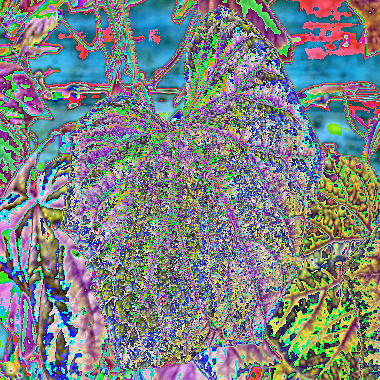

In [16]:
toimage = transforms.ToPILImage()
toimage(train_dataset[np.random.randint(1, 1000)]['img'])

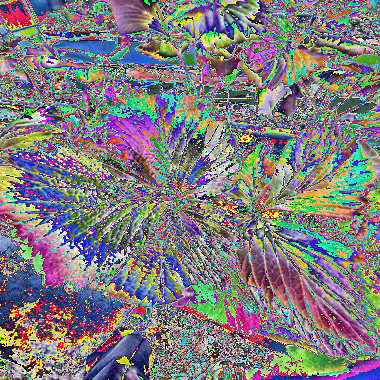

In [17]:
toimage(val_dataset[np.random.randint(1, 1000)]['img'])

# 모델

## 이미지 분류 모델 : EfficientNetb4

In [18]:
from efficientnet_pytorch import EfficientNet
from torchinfo import summary

class CNN_Encoder(nn.Module):
    def __init__(self, embedding_dim, rate=0.2):
        super(CNN_Encoder, self).__init__()
        self.model = EfficientNet.from_pretrained('efficientnet-b4')    # (input, output) = (380, 1792)
    
    def forward(self, inputs):
        output = self.model(inputs)
        return output

## 시계열 모델 : LSTM

In [19]:
class RNN_Decoder(nn.Module):
    def __init__(self, max_len, embedding_dim, num_features, class_n, rate):
        super(RNN_Decoder, self).__init__()
        self.lstm = nn.LSTM(max_len, embedding_dim)
        self.rnn_fc = nn.Linear(num_features*embedding_dim, rnn_fc_dim)
        self.final_layer = nn.Linear(1000+rnn_fc_dim, class_n) # cnn out_dim + lstm out_dim
        self.dropout = nn.Dropout(rate)

    def forward(self, enc_out, dec_inp):
        hidden, _ = self.lstm(dec_inp) # hidden dim : (Batch, csv_feature, embedding_dim)
        hidden = hidden.view(hidden.size(0), -1)    # (Batch, num_features*embedding_dim)
        hidden = self.rnn_fc(hidden)    # (, 1000)

        fc_input = torch.cat([enc_out, hidden], dim=1) # enc_out + hidden 
        output = self.final_layer(fc_input)
        output = self.dropout(output)
        return output

## 앙상블

In [20]:
class CNN2RNN(nn.Module):
    def __init__(self, max_len, embedding_dim, num_features, class_n, rate):
        super(CNN2RNN, self).__init__()
        self.cnn = CNN_Encoder(embedding_dim, rate)
        self.rnn = RNN_Decoder(max_len, embedding_dim, num_features, class_n, rate)
        
    def forward(self, img, seq):
        cnn_output = self.cnn(img)
        output = self.rnn(cnn_output, seq)  # concat - 1000+1000
        
        return output

In [21]:
model = CNN2RNN(max_len=max_len, embedding_dim=embedding_dim, num_features=num_features, class_n=class_n, rate=fc_dropout_rate)
model = model.to(device)

Loaded pretrained weights for efficientnet-b4


In [22]:
# hidden dim : (Batch, csv_feature, embedding_dim)
# final output : (Batch, n_class)
# model = model.cpu()
# sample_batch = next(iter(train_dataloader))
# sample_img = sample_batch['img']
# sample_csv = sample_batch['csv_feature']
# sample_out = model(sample_img, sample_csv)
# sample_out
# OUT SHAPE : (16, 111)
# RuntimeError: mat1 and mat2 shapes cannot be multiplied (16x2000 and 2792x111)
# import gc
# gc.collect()

# 학습

In [23]:
class FocalLoss(nn.Module):
    def __init__(self, alpha=1, gamma=2, logits=False, reduce=True):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.logits = logits
        self.reduce = reduce

    def forward(self, inputs, targets):
        ce_loss = nn.CrossEntropyLoss(reduction='sum')(inputs, targets)

        pt = torch.exp(-ce_loss)
        F_loss = self.alpha * (1-pt)**self.gamma * ce_loss

        if self.reduce:
            return torch.mean(F_loss)
        else:
            return F_loss

# class FocalLoss(nn.Module):
#     def __init__(self, alpha=.25, gamma=2):
#         super(FocalLoss, self).__init__()
#         self.alpha = torch.tensor([alpha, 1-alpha]).cuda()
#         self.gamma = gamma

#     def forward(self, inputs, targets):
#         ce_loss = nn.CrossEntropyLoss(reduction='sum')(inputs, targets)
#         targets = targets.type(torch.long)
#         at = self.alpha.gather(0, targets.data.view(-1))
#         pt = torch.exp(-ce_loss)
#         F_loss = at*(1-pt)**self.gamma * ce_loss
#         return F_loss.mean()

In [24]:
import math
from torch.optim.lr_scheduler import _LRScheduler

class CosineAnnealingWarmUpRestarts(_LRScheduler):
    def __init__(self, optimizer, T_0=100, T_mult=1, eta_max=0.1, T_up=0, gamma=1., last_epoch=-1):
        if T_0 <= 0 or not isinstance(T_0, int):
            raise ValueError("Expected positive integer T_0, but got {}".format(T_0))
        if T_mult < 1 or not isinstance(T_mult, int):
            raise ValueError("Expected integer T_mult >= 1, but got {}".format(T_mult))
        if T_up < 0 or not isinstance(T_up, int):
            raise ValueError("Expected positive integer T_up, but got {}".format(T_up))
        self.T_0 = T_0
        self.T_mult = T_mult
        self.base_eta_max = eta_max
        self.eta_max = eta_max
        self.T_up = T_up
        self.T_i = T_0
        self.gamma = gamma
        self.cycle = 0
        self.T_cur = last_epoch
        super(CosineAnnealingWarmUpRestarts, self).__init__(optimizer, last_epoch)
    
    def get_lr(self):
        if self.T_cur == -1:
            return self.base_lrs
        elif self.T_cur < self.T_up:
            return [(self.eta_max - base_lr)*self.T_cur / self.T_up + base_lr for base_lr in self.base_lrs]
        else:
            return [base_lr + (self.eta_max - base_lr) * (1 + math.cos(math.pi * (self.T_cur-self.T_up) / (self.T_i - self.T_up))) / 2
                    for base_lr in self.base_lrs]

    def step(self, epoch=None):
        if epoch is None:
            epoch = self.last_epoch + 1
            self.T_cur = self.T_cur + 1
            if self.T_cur >= self.T_i:
                self.cycle += 1
                self.T_cur = self.T_cur - self.T_i
                self.T_i = (self.T_i - self.T_up) * self.T_mult + self.T_up
        else:
            if epoch >= self.T_0:
                if self.T_mult == 1:
                    self.T_cur = epoch % self.T_0
                    self.cycle = epoch // self.T_0
                else:
                    n = int(math.log((epoch / self.T_0 * (self.T_mult - 1) + 1), self.T_mult))
                    self.cycle = n
                    self.T_cur = epoch - self.T_0 * (self.T_mult ** n - 1) / (self.T_mult - 1)
                    self.T_i = self.T_0 * self.T_mult ** (n)
            else:
                self.T_i = self.T_0
                self.T_cur = epoch
                
        self.eta_max = self.base_eta_max * (self.gamma**self.cycle)
        self.last_epoch = math.floor(epoch)
        for param_group, lr in zip(self.optimizer.param_groups, self.get_lr()):
            param_group['lr'] = lr

## Train control

In [25]:
from torch.optim.lr_scheduler import ReduceLROnPlateau

optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)
# criterion = nn.CrossEntropyLoss(reduction='sum')
criterion = FocalLoss()
# scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, threshold=0.1, patience=10, threshold_mode='rel', verbose=True)
scheduler = CosineAnnealingWarmUpRestarts(optimizer, T_0=10, eta_max=learning_rate, T_up=2, gamma=0.9)

In [26]:
import torch.nn as nn

def accuracy_function(real, pred):    
    real = real.cpu()
    pred = torch.argmax(pred, dim=1).cpu()
    score = f1_score(real, pred, average='macro')
    return score

def train(model, loader, epoch, nb_epochs):
    print(f'Epoch {epoch+1}/{nb_epochs}')
    running_loss = 0.0
    running_score = 0.0
    running_f1 = 0.0
    running_corrects = 0
    model.train()
    scaler = torch.cuda.amp.GradScaler()

    for idx, batch in enumerate(tqdm(loader)):
        img = batch['img'].to(device)
        csv_feature = batch['csv_feature'].to(device)
        label = batch['label'].to(device)
        
        optimizer.zero_grad()
        with torch.cuda.amp.autocast():
            output = model(img, csv_feature)
            loss = criterion(output, label)

        scaler.scale(loss).backward() # ADDED - mixed precision + gradient clipping
        nn.utils.clip_grad_norm_(model.parameters(), max_norm=10)
        scaler.step(optimizer)
        scaler.update()
        score = accuracy_function(label, output)
        pred = torch.argmax(output, dim=1)

        running_loss += loss.item() 
        running_score ++ score
        running_corrects += torch.sum(label==pred)
        
    epoch_loss = running_loss / len(loader.dataset)
    epoch_score = running_corrects / len(loader.dataset)
    writer.add_scalar('Loss/train', epoch_loss, epoch)
    writer.add_scalar('F1_score/train', epoch_score, epoch)
    writer.add_scalar('learning_rate', optimizer.param_groups[0]["lr"], epoch)
    print(f'Train loss: {epoch_loss:.6f}, Train F1: {epoch_score:.6f}, lr: {optimizer.param_groups[0]["lr"]:.6f}')
    # scheduler.step()
    
def validate(model, loader, epoch, nb_epochs):
    running_loss = 0.0
    running_score = 0.0
    running_f1 = 0.0
    running_corrects = 0
    model.eval()
    with torch.no_grad():
        for idx, batch in enumerate(loader):
            img = batch['img'].to(device)
            csv_feature = batch['csv_feature'].to(device)
            label = batch['label'].to(device)
            output = model(img, csv_feature)
            loss = criterion(output, label)
            score = accuracy_function(label, output)
            pred = torch.argmax(output, dim=1)
            
            running_loss += loss.item() 
            running_score ++ score
            running_corrects += torch.sum(label==pred)
            
        epoch_loss = running_loss / len(loader.dataset)
        epoch_score = running_corrects / len(loader.dataset)
        writer.add_scalar('Loss/valid', epoch_loss, epoch)
        writer.add_scalar('F1_score/valid', epoch_score, epoch)
        # writer.add_scalar('learning_rate', optimizer.param_groups[0]["lr"], epoch)
        print("Val loss: {:.6f}, Val F1: {:.6f}".format(epoch_loss, epoch_score)) # lr: {optimizer.param_groups[0]["lr"]:.6f}')
        print(f"{running_corrects}/{len(loader.dataset)} correct")
        val_score_list.append(epoch_score)
        
        if np.max(val_score_list) == val_score_list[-1]:  # 현재 모델이 성능 최댓값이면 저장 
            torch.save(model.state_dict(), save_path)


In [27]:
from torch.utils.tensorboard import SummaryWriter
import os
import math

writer = SummaryWriter(log_dir='logs/' + save_name)
val_score_list = []

for epoch in range(epochs):
    train(model, train_dataloader, epoch, epochs)
    validate(model, val_dataloader, epoch, epochs) 
    
max_val = np.max(val_score_list)
print(max_val)

Epoch 1/30


100%|██████████| 193/193 [10:13<00:00,  3.18s/it]


Train loss: 1.609612, Train F1: 0.634728, lr: 0.000100
Val loss: 0.280964, Val F1: 0.917678
1059/1154 correct
Epoch 2/30


100%|██████████| 193/193 [09:34<00:00,  2.98s/it]


Train loss: 0.819973, Train F1: 0.792109, lr: 0.000100
Val loss: 0.131350, Val F1: 0.948873
1095/1154 correct
Epoch 3/30


100%|██████████| 193/193 [09:29<00:00,  2.95s/it]


Train loss: 0.775714, Train F1: 0.798613, lr: 0.000100
Val loss: 0.208534, Val F1: 0.939341
1084/1154 correct
Epoch 4/30


100%|██████████| 193/193 [09:19<00:00,  2.90s/it]


Train loss: 0.721821, Train F1: 0.819857, lr: 0.000100
Val loss: 0.269892, Val F1: 0.937608
1082/1154 correct
Epoch 5/30


100%|██████████| 193/193 [09:30<00:00,  2.96s/it]


Train loss: 0.667060, Train F1: 0.822241, lr: 0.000100
Val loss: 0.190106, Val F1: 0.960139
1108/1154 correct
Epoch 6/30


100%|██████████| 193/193 [09:27<00:00,  2.94s/it]


Train loss: 0.677122, Train F1: 0.821808, lr: 0.000100
Val loss: 0.338360, Val F1: 0.961872
1110/1154 correct
Epoch 7/30


100%|██████████| 193/193 [09:36<00:00,  2.99s/it]


Train loss: 0.690647, Train F1: 0.822025, lr: 0.000100
Val loss: 0.353323, Val F1: 0.964471
1113/1154 correct
Epoch 8/30


100%|██████████| 193/193 [09:36<00:00,  2.99s/it]


Train loss: 0.757071, Train F1: 0.812920, lr: 0.000100
Val loss: 0.616676, Val F1: 0.949740
1096/1154 correct
Epoch 9/30


100%|██████████| 193/193 [09:26<00:00,  2.93s/it]


Train loss: 0.699687, Train F1: 0.823976, lr: 0.000100
Val loss: 0.669648, Val F1: 0.964471
1113/1154 correct
Epoch 10/30


100%|██████████| 193/193 [09:26<00:00,  2.94s/it]


Train loss: 0.707357, Train F1: 0.824626, lr: 0.000100
Val loss: 0.500473, Val F1: 0.972270
1122/1154 correct
Epoch 11/30


100%|██████████| 193/193 [09:23<00:00,  2.92s/it]


Train loss: 0.721744, Train F1: 0.822025, lr: 0.000100
Val loss: 0.894121, Val F1: 0.953206
1100/1154 correct
Epoch 12/30


100%|██████████| 193/193 [09:15<00:00,  2.88s/it]


Train loss: 0.668325, Train F1: 0.826794, lr: 0.000100
Val loss: 0.893216, Val F1: 0.954939
1102/1154 correct
Epoch 13/30


100%|██████████| 193/193 [09:29<00:00,  2.95s/it]


Train loss: 0.666497, Train F1: 0.821374, lr: 0.000100
Val loss: 0.682376, Val F1: 0.966205
1115/1154 correct
Epoch 14/30


100%|██████████| 193/193 [09:20<00:00,  2.90s/it]


Train loss: 0.699509, Train F1: 0.818990, lr: 0.000100
Val loss: 0.815811, Val F1: 0.962738
1111/1154 correct
Epoch 15/30


100%|██████████| 193/193 [09:29<00:00,  2.95s/it]


Train loss: 0.675193, Train F1: 0.820941, lr: 0.000100
Val loss: 0.693426, Val F1: 0.969671
1119/1154 correct
Epoch 16/30


100%|██████████| 193/193 [09:29<00:00,  2.95s/it]


Train loss: 0.673106, Train F1: 0.824843, lr: 0.000100
Val loss: 0.676677, Val F1: 0.968804
1118/1154 correct
Epoch 17/30


100%|██████████| 193/193 [09:26<00:00,  2.93s/it]


Train loss: 0.687503, Train F1: 0.823542, lr: 0.000100
Val loss: 0.470914, Val F1: 0.967938
1117/1154 correct
Epoch 18/30


100%|██████████| 193/193 [09:27<00:00,  2.94s/it]


Train loss: 0.665109, Train F1: 0.828745, lr: 0.000100
Val loss: 1.039900, Val F1: 0.969671
1119/1154 correct
Epoch 19/30


100%|██████████| 193/193 [09:24<00:00,  2.93s/it]


Train loss: 0.665959, Train F1: 0.820724, lr: 0.000100
Val loss: 1.003827, Val F1: 0.963605
1112/1154 correct
Epoch 20/30


100%|██████████| 193/193 [09:19<00:00,  2.90s/it]


Train loss: 0.671174, Train F1: 0.820724, lr: 0.000100
Val loss: 0.977868, Val F1: 0.965338
1114/1154 correct
Epoch 21/30


100%|██████████| 193/193 [09:26<00:00,  2.94s/it]


Train loss: 0.640640, Train F1: 0.829395, lr: 0.000100
Val loss: 0.924668, Val F1: 0.968804
1118/1154 correct
Epoch 22/30


100%|██████████| 193/193 [09:19<00:00,  2.90s/it]


Train loss: 0.618388, Train F1: 0.834815, lr: 0.000100
Val loss: 0.964208, Val F1: 0.969671
1119/1154 correct
Epoch 23/30


100%|██████████| 193/193 [09:26<00:00,  2.93s/it]


Train loss: 0.634842, Train F1: 0.827444, lr: 0.000100
Val loss: 0.931662, Val F1: 0.970537
1120/1154 correct
Epoch 24/30


100%|██████████| 193/193 [09:26<00:00,  2.94s/it]


Train loss: 0.673337, Train F1: 0.818773, lr: 0.000100
Val loss: 0.942790, Val F1: 0.968804
1118/1154 correct
Epoch 25/30


100%|██████████| 193/193 [09:27<00:00,  2.94s/it]


Train loss: 0.640242, Train F1: 0.829178, lr: 0.000100
Val loss: 0.896643, Val F1: 0.969671
1119/1154 correct
Epoch 26/30


100%|██████████| 193/193 [09:28<00:00,  2.94s/it]


Train loss: 0.630468, Train F1: 0.828095, lr: 0.000100
Val loss: 0.951734, Val F1: 0.966205
1115/1154 correct
Epoch 27/30


100%|██████████| 193/193 [09:22<00:00,  2.91s/it]


Train loss: 0.636897, Train F1: 0.821808, lr: 0.000100
Val loss: 0.956535, Val F1: 0.966205
1115/1154 correct
Epoch 28/30


100%|██████████| 193/193 [09:33<00:00,  2.97s/it]


Train loss: 0.630098, Train F1: 0.828311, lr: 0.000100
Val loss: 0.983767, Val F1: 0.967071
1116/1154 correct
Epoch 29/30


100%|██████████| 193/193 [09:34<00:00,  2.98s/it]


Train loss: 0.632927, Train F1: 0.827661, lr: 0.000100
Val loss: 0.962898, Val F1: 0.967938
1117/1154 correct
Epoch 30/30


100%|██████████| 193/193 [09:37<00:00,  2.99s/it]


Train loss: 0.624900, Train F1: 0.825927, lr: 0.000100
Val loss: 0.973274, Val F1: 0.967071
1116/1154 correct
tensor(0.9723, device='cuda:0')


# 학습 결과/추론

In [28]:
def predict(loader):
    model.eval()
    results = []

    for batch, batch_item in enumerate(tqdm(loader)):
        img = batch_item['img'].to(device)
        seq = batch_item['csv_feature'].to(device)
        with torch.no_grad():
            output = model(img, seq)
        output = torch.tensor(torch.argmax(output, dim=1), dtype=torch.int32).cpu().numpy()
        results.extend(output)    
    return results

model = CNN2RNN(max_len=max_len, embedding_dim=embedding_dim, num_features=num_features, class_n=class_n, rate=fc_dropout_rate)
model.load_state_dict(torch.load(save_path, map_location=device))
model.to(device)

preds = predict(test_dataloader)
# 25min

Loaded pretrained weights for efficientnet-b4


100%|██████████| 2163/2163 [20:09<00:00,  1.79it/s]


In [29]:
preds = np.array([label_decoder[int(val)] for val in preds])

# 제출 파일 생성

In [30]:
submission = pd.read_csv('data/sample_submission.csv')
submission['label'] = preds
submission

,image,label
0,10000,6_00_0
1,10001,5_b6_1
2,10002,4_00_0
3,10003,3_00_0
4,10004,3_b8_1
...,...,...
51901,67673,4_00_0
51902,67674,3_b7_1
51903,67675,6_00_0
51904,67676,2_a5_2


In [31]:
submission.to_csv(f'{save_name}_{max_val:6f}.csv', index=False)